In [38]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [96]:
# Configurations
class Config:
    MODEL_NAME = "distilbert-base-uncased"
    MAX_LEN = 128
    BATCH_SIZE = 16
    EPOCHS = 5
    LR = 2e-5
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load and combine data from two CSV files
data1 = pd.read_csv(r"Downloads\GroceryDB_training_dataset_SRFNDSS_2001_2018_NOVA123_multi_compositions_12Nutrients.csv", usecols=["ingredients", "novaclass"])
data2 = pd.read_csv(r"Downloads\FNDDS_2015_ingredients_ManualNOVA_FoodProX_62_CCNR2019.csv", usecols=["ingredients", "novaclass"])


# Combine the two datasets
data = pd.concat([data1, data2], ignore_index=True)

# Drop missing values
data = data.dropna(subset=["ingredients", "novaclass"])

# Split Data into Train, Validation, and Test
data_train, data_temp = train_test_split(data, test_size=0.3, random_state=42)
data_val, data_test = train_test_split(data_temp, test_size=0.5, random_state=42)
data_train = data_train.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)




In [116]:
# Tokenizer and Dataset Class
tokenizer = DistilBertTokenizer.from_pretrained(Config.MODEL_NAME)

def tokenize_data(texts, labels):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=Config.MAX_LEN)
    return encodings, labels - 1  # Adjust labels to start from 0


class FoodDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item



In [118]:
# Prepare Datasets and Dataloaders
train_encodings, train_labels = tokenize_data(data_train["ingredients"], data_train["novaclass"].astype(int))
val_encodings, val_labels = tokenize_data(data_val["ingredients"], data_val["novaclass"].astype(int))
test_encodings, test_labels = tokenize_data(data_test["ingredients"], data_test["novaclass"].astype(int))

train_dataset = FoodDataset(train_encodings, train_labels)
val_dataset = FoodDataset(val_encodings, val_labels)
test_dataset = FoodDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False)


In [120]:
# Model Initialization
model = DistilBertForSequenceClassification.from_pretrained(Config.MODEL_NAME, num_labels=len(data["novaclass"].unique()))
model.to(Config.DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LR)
criterion = nn.CrossEntropyLoss()

def train_epoch(loader, model, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(Config.DEVICE)
        attention_mask = batch['attention_mask'].to(Config.DEVICE)
        labels = batch['labels'].to(Config.DEVICE)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy

def eval_epoch(loader, model, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(Config.DEVICE)
            attention_mask = batch['attention_mask'].to(Config.DEVICE)
            labels = batch['labels'].to(Config.DEVICE)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            total_loss += loss.item()
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [122]:
# Training Loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(Config.EPOCHS):
    train_loss, train_acc = train_epoch(train_loader, model, optimizer, criterion)
    val_loss, val_acc = eval_epoch(val_loader, model, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{Config.EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")


Epoch 1/5
Train Loss: 0.3748, Train Accuracy: 0.8718
Val Loss: 0.1828, Val Accuracy: 0.9471
Epoch 2/5
Train Loss: 0.1176, Train Accuracy: 0.9649
Val Loss: 0.1325, Val Accuracy: 0.9607
Epoch 3/5
Train Loss: 0.0679, Train Accuracy: 0.9806
Val Loss: 0.1028, Val Accuracy: 0.9703
Epoch 4/5
Train Loss: 0.0433, Train Accuracy: 0.9874
Val Loss: 0.0945, Val Accuracy: 0.9733
Epoch 5/5
Train Loss: 0.0335, Train Accuracy: 0.9898
Val Loss: 0.0904, Val Accuracy: 0.9778


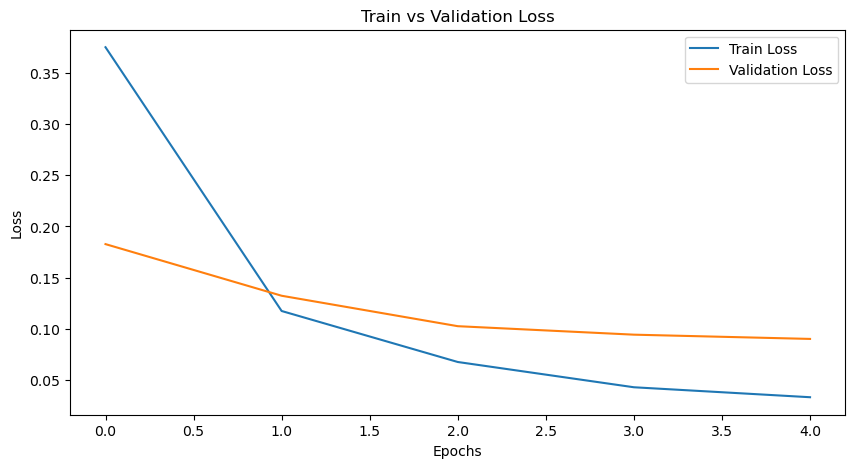

In [124]:
# Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train vs Validation Loss")
plt.show()




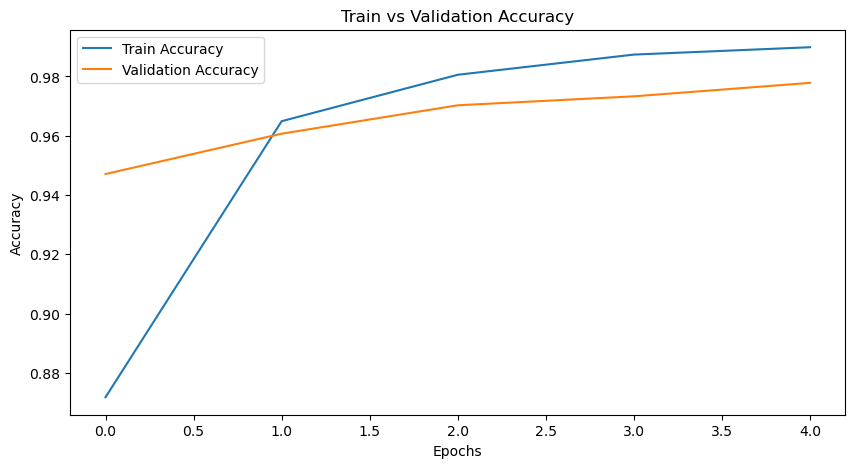

In [126]:
# Plot Training vs Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train vs Validation Accuracy")
plt.show()

In [128]:
# Evaluate on Test Set
model.eval()
test_preds, test_labels_list = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(Config.DEVICE)
        attention_mask = batch['attention_mask'].to(Config.DEVICE)
        labels = batch['labels'].to(Config.DEVICE)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels_list.extend(labels.cpu().numpy())


In [129]:
# Compute Test Accuracy
test_accuracy = accuracy_score(test_labels_list, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9829


In [132]:
# Save the model
torch.save(model.state_dict(), "distilbert_food_classifier.pth")


In [160]:
def predict_ingredients(ingredients_text, model, tokenizer):
    # Tokenize the input
    model.eval()
    inputs = tokenizer(ingredients_text, truncation=True, padding=True, max_length=Config.MAX_LEN, return_tensors="pt")
    inputs = {key: val.to(Config.DEVICE) for key, val in inputs.items()}
    
    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        preds = outputs.logits.argmax(dim=1).item()  # Get the predicted class
    return preds + 1  # Adjust back to original label range [1, 4]

# Example test
lays_ingredients = "spinach, boiled"
predicted_class = predict_ingredients(lays_ingredients, model, tokenizer)
print(f"Predicted Class: {predicted_class}")


Predicted Class for Lays: 1
